In [1]:
#Imports y configuración
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# Opciones visuales
plt.rcParams['figure.figsize'] = (10,5)
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


1) Cargar y procesar los CSV (obtener promedios mensuales por año)

In [2]:
# Lectura y preprocesado
files = {
    2023: "PM10_2023.csv",
    2024: "PM10_2024.csv",
    2025: "PM10_2025.csv"
}

dfs = []
for year, path in files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Archivo no encontrado: {path}")
    df = pd.read_csv(path)
    date_col = 'Date'
    value_col = 'Daily Mean PM10 Concentration'
    if date_col not in df.columns:
        raise KeyError(f"El archivo {path} no tiene la columna '{date_col}'.")
    if value_col not in df.columns:
        raise KeyError(f"El archivo {path} no tiene la columna '{value_col}'.")
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])  # eliminar filas con fecha inválida
    df['Year'] = df[date_col].dt.year
    df['Month'] = df[date_col].dt.month
    dfs.append(df[['Year','Month', value_col]])

# concatenar
df_total = pd.concat(dfs, ignore_index=True)

# calcular promedio mensual por año
df_monthly = df_total.groupby(['Year','Month'])['Daily Mean PM10 Concentration'].mean().unstack(level=1)

# asegurar columnas 1..12 (meses)
df_monthly = df_monthly.reindex(columns=range(1,13))

# renombrar columnas a nombres de mes
df_monthly.columns = month_names
df_pivot = df_monthly.reset_index()  # DataFrame con Year + Jan..Dec

# Mostrar
display(df_pivot)


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2023,12.408511,17.621359,20.369748,18.315556,18.863014,23.863636,23.158996,21.973913,21.794118,20.556075,20.492611,15.156398
1,2024,12.928934,18.973404,17.815385,19.880435,16.983146,18.083832,18.204301,24.990521,16.687805,25.642512,15.370000,15.029586
2,2025,15.678571,17.177419,22.379487,19.663551,14.954955,19.635593,18.836735,14.616000,24.841270,NaN,NaN,NaN


2) Preparar y entrenar (una regresión por mes usando 2023 y 2024)

In [19]:
# Entrenar por mes y predecir 2025
preds = {}
models = {}
fallback_info = {}

for m in month_names:
    # extraer valores por año (puede haber NaN)
    val_2023 = df_pivot.loc[df_pivot['Year'] == 2023, m].squeeze() if (df_pivot['Year'] == 2023).any() else np.nan
    val_2024 = df_pivot.loc[df_pivot['Year'] == 2024, m].squeeze() if (df_pivot['Year'] == 2024).any() else np.nan

    X = []
    y = []
    if not pd.isna(val_2023):
        X.append([2023]); y.append(float(val_2023))
    if not pd.isna(val_2024):
        X.append([2024]); y.append(float(val_2024))

    if len(y) >= 2:
        model = LinearRegression()
        model.fit(np.array(X), np.array(y))
        pred_2025 = model.predict(np.array([[2025]]))[0]
        models[m] = model
        fallback_info[m] = "regression (2 pts)"
    elif len(y) == 1:
        pred_2025 = y[-1]
        fallback_info[m] = "fallback: single value used"
    else:
        pred_2025 = np.nan
        fallback_info[m] = "no data"

    preds[m] = pred_2025

pred_df = pd.DataFrame([preds], index=[2025])[month_names]
print("Predicciones 2025 (por mes):")
display(pred_df.T)
print("\nMétodo usado por mes:")
display(pd.Series(fallback_info))


Predicciones 2025 (por mes):


,2025
Jan,13.449357
Feb,20.325449
Mar,15.261021
Apr,21.445314
May,15.103278
Jun,12.304028
Jul,13.249606
Aug,28.007130
Sep,11.581492
Oct,30.728949



Método usado por mes:


,0
Jan,regression (2 pts)
Feb,regression (2 pts)
Mar,regression (2 pts)
Apr,regression (2 pts)
May,regression (2 pts)
Jun,regression (2 pts)
Jul,regression (2 pts)
Aug,regression (2 pts)
Sep,regression (2 pts)
Oct,regression (2 pts)


3) Extraer los reales de 2025 y alinear meses

In [4]:
# Valores reales 2025
if (df_pivot['Year'] == 2025).any():
    real_2025 = df_pivot.loc[df_pivot['Year'] == 2025, month_names].iloc[0]
else:
    # Si no hay fila anual para 2025 (por ejemplo, no hay promedios), lo construimos desde los datos diarios:
    # Aunque nuestro paso 1 ya agrupa por año/mes, esto es una defensa adicional.
    real_2025 = df_monthly.loc[2025] if 2025 in df_monthly.index else pd.Series([np.nan]*12, index=month_names)

display(real_2025)


,2
Jan,15.678571
Feb,17.177419
Mar,22.379487
Apr,19.663551
May,14.954955
Jun,19.635593
Jul,18.836735
Aug,14.616000
Sep,24.841270
Oct,NaN


4) Métricas de error (MAE y RMSE) y tabla de errores por mes

In [17]:
error_table = pd.DataFrame({
    "Month": valid_months,
    "Real": y_true,
    "Pred": y_pred,
    "AbsError": np.abs(y_true - y_pred)
})

# Calcular métricas globales para la gráfica
mae = error_table['AbsError'].mean()
rmse = np.sqrt((error_table['AbsError'] ** 2).mean())



5) Gráficas comparativas (líneas y barras de error)

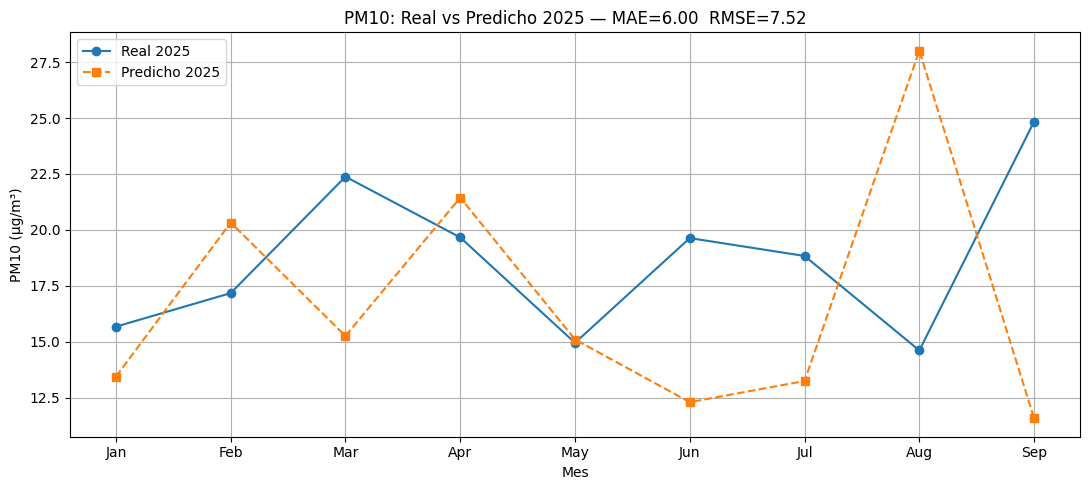

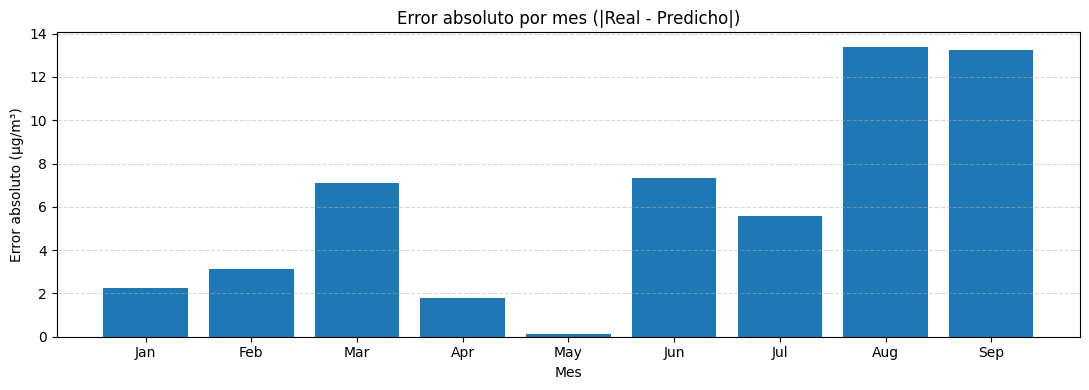

Resultados guardados en carpeta `results/`.


In [18]:
# Gráficos
if len(valid_months) > 0:
    # gráfico de líneas
    fig, ax = plt.subplots(figsize=(11,5))
    ax.plot(valid_months, y_true, marker='o', label='Real 2025')
    ax.plot(valid_months, y_pred, marker='s', linestyle='--', label='Predicho 2025')
    ax.set_xlabel('Mes')
    ax.set_ylabel('PM10 (µg/m³)')
    ax.set_title(f'PM10: Real vs Predicho 2025 — MAE={mae:.2f}  RMSE={rmse:.2f}')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # barras de error absoluto
    fig2, ax2 = plt.subplots(figsize=(11,4))
    ax2.bar(valid_months, error_table['AbsError'])
    ax2.set_xlabel('Mes')
    ax2.set_ylabel('Error absoluto (µg/m³)')
    ax2.set_title('Error absoluto por mes (|Real - Predicho|)')
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # guardar resultados en carpeta results/
    os.makedirs('results', exist_ok=True)
    pred_df.to_csv('results/predictions_2025.csv', index_label='Year')
    error_table.to_csv('results/error_by_month_2025.csv', index=False)
    fig.savefig('results/pm10_real_vs_pred_2025.png')
    fig2.savefig('results/pm10_error_by_month_2025.png')
    print("Resultados guardados en carpeta `results/`.")
else:
    print("No se generaron gráficos: no hay meses válidos para comparar.")

